In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 9.9 MB/s 


In [ ]:
import torch
import torch.nn as nn

In [ ]:
def nin_block(out_channels, kernel_size, strides, padding):
  return nn.Sequential(
      nn.LazyConv2d(out_channels, kernel_size, strides, padding),
      nn.ReLU(),
      nn.LazyConv2d(out_channels, kernel_size = 1),
      nn.ReLU(),
      nn.LazyConv2d(out_channels, kernel_size = 1),
      nn.ReLU()
  )

In [ ]:
class NiN(nn.Module):
  def __init__(self, lr = 0.1, num_classes = 10):
    super().__init__()
    self.lr = lr
    self.num_classes = num_classes
    self.net = nn.Sequential(
        nin_block(96, kernel_size = 11, strides = 4, padding = 0),
        nn.MaxPool2d(3, stride = 2),
        nin_block(256, kernel_size = 5, strides = 1, padding = 2),
        nn.MaxPool2d(3, stride = 2),
        nn.Dropout(0.5),
        nin_block(num_classes, kernel_size = 3, strides = 1, padding = 1),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten()
    )
  
  def forward(self, X):
    return self.net(X)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
from torchvision.transforms import Compose

In [ ]:
transform = Compose(
    [Resize((224, 224)),
    ToTensor()]
)

In [ ]:
train_data = FashionMNIST(root = './data', train = True,
                          transform = transform, target_transform = None,
                          download = True)

test_data = FashionMNIST(root = './data', train = False,
                          transform = transform, target_transform = None,
                          download = True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 128, shuffle = True)

In [ ]:
model = NiN(lr = 0.05).to(device)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)
acc = Accuracy(task = 'multiclass', num_classes = 10).to(device)

In [ ]:
def train_step(model, train_loader, criterion, optimizer, acc, device):
  train_loss = 0
  train_acc = 0

  for X, y in train_loader:
    X, y = X.to(device), y.to(device)
    preds = model(X)
    loss = criterion(preds, y)
    train_loss += loss.item()
    train_acc += acc(preds, y).item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  return train_loss, train_acc

In [ ]:
def test_step(model, test_loader, criterion, acc, device):
  test_loss = 0
  test_acc = 0

  model.eval()
  with torch.inference_mode():
    for X, y in test_loader:
      X, y = X.to(device), y.to(device)
      preds = model(X)
      test_loss += criterion(preds, y).item()
      test_acc += acc(preds, y).item()

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    return test_loss, test_acc

In [ ]:
epochs = 10

train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(epochs):
  train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, acc, device)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_loss, test_acc = test_step(model, test_loader, criterion, acc, device)
  test_losses.append(test_loss)
  test_accs.append(test_acc)

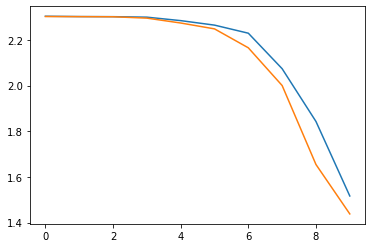

In [ ]:
plt.plot(range(epochs), train_losses)
plt.plot(range(epochs), test_losses)

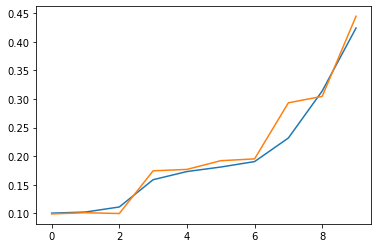

In [ ]:
plt.plot(range(epochs), train_accs)
plt.plot(range(epochs), test_accs)